In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nltk
import re
import matplotlib.pyplot as plt
import keras
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input,decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50

from keras.preprocessing import image
import numpy as np
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout, Embedding, LSTM
from keras.layers.merge import add  


In [4]:
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [5]:
captions=readTextFile('/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt')
captions=captions.split('\n')[1:-1]

In [6]:
captions[0]

'1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .'

In [7]:
captions[0]

'1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .'

In [8]:
captions[1].split(',')

['1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .']

In [9]:
#Dictionary to map each image with its multiple ids
descriptions={}
for i in captions:
    first,second=i.split('\t')
    img_name=first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)
  

In [10]:
img_name

'997722733_0cb5439472'

In [11]:
descriptions['997722733_0cb5439472']

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

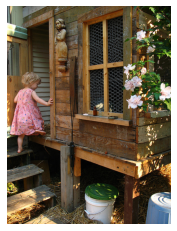

In [12]:
IMG_PATH='/content/drive/MyDrive/Flickr8k_Dataset/Flicker8k_Dataset/'
import cv2
import matplotlib.pyplot as plt
img=cv2.imread(IMG_PATH+ '1000268201_693b08cb0e.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()



In [13]:
#Data Cleaning
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+","  ", sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [14]:
clean_text('I am a good boy')


'am good boy'

In [15]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
        

In [16]:
#Write the Preproceessed data in a text file
with open("description_1.txt",'w') as f:
    f.write(str(descriptions))


In [17]:
#Vocabulary

In [18]:
descriptions=None
with open("description_1.txt",'r') as f:
    descriptions=f.read()

descriptions=json.loads(descriptions.replace("'","\""))


In [19]:
print(type(descriptions))

<class 'dict'>


In [20]:
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split())  for sentence in descriptions[key]]
vocab_size=len(vocab)    
print("vocab Size : %d"%len(vocab))

vocab Size : 8423


In [21]:
#Total Number of words across all the sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total Words %d"%len(total_words))    

Total Words 373823


In [22]:
#Filter words from colab according to certain threshold frequency
from collections import Counter
counter=Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8423


In [23]:
#Sort the dictionary according to frequency count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#filter
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt ]

In [24]:
len(total_words)

1845

Prepare Train/Test Data

In [25]:
train_file_data=readTextFile("/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data=readTextFile("/content/drive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt")


In [26]:
train=[row.split(".")[0] for row in train_file_data.split("\n")[1:-1]]
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]


In [27]:
train[0]

'2903617548_d3e38d7f88'

In [28]:
#Preapare the description of training data
#add start and end token to our training data
train_descriptions={}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)
        

In [29]:
train_descriptions['1000268201_693b08cb0e']

['startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Transfer Learning¶

step-1: Image Feature Extraction

In [30]:
model=ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

102981632/102967424 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [31]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [32]:
model_new=Model(model.input,model.layers[-2].output)

In [33]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)# To make the image 4d
    # Normalization
    img=preprocess_input(img)
    return img

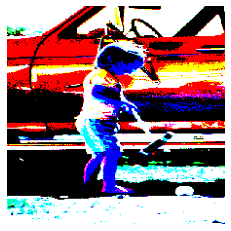

In [34]:
img=preprocess_img(IMG_PATH+'2903617548_d3e38d7f88.jpg') 
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [35]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [62]:
start=time()
encoding_train={}
for ix,img in enumerate(train):
    img='/content/drive/MyDrive/Flickr8k_Dataset/Flicker8k_Dataset/{}.jpg'.format(train[ix])
    encoding_train[img[len(IMG_PATH):]]=encode_image(img)
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
end_t=time()
print("Total Time Taken: ", end_t-start)


Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [37]:
#store everything to the disk
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [38]:
start=time()
encoding_test={}
for ix,img_id in enumerate(test):
    img_path=IMG_PATH+ img_id+".jpg"
    encoding_test[img_id]=encode_image(img_path)
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
end_t=time()
print("Total Time Taken: ", end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Total Time Taken:  816.8640406131744


In [39]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [40]:
#Data Preprocessing for captions
word_to_idx={}
idx_to_word={}
for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word
    
 

In [41]:
word_to_idx["dog"]

6

In [42]:
idx_to_word[6]

'dog'

In [43]:
print(len(word_to_idx))

1845


In [44]:
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846
idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847



In [45]:

print(len(word_to_idx)+1)

1848


In [46]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)

35


In [47]:
#Data Loader
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len,batch_size):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    xi = seq[0:i]
                    yi = seq[i]

                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]

                    yi = to_categorical([yi], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)

            if n==batch_size:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

                    
                

In [48]:

#Word Embedding
f=open('/content/drive/MyDrive/archive/glove.6B.50d.txt', encoding='utf8')

In [49]:
embedding_index={}
for line in f:
    values=line.split()
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
    

In [50]:
f.close()


In [51]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    return matrix

In [52]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(8423, 50)

In [53]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [54]:
#Model Architecture
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [55]:
#Caption as input
input_captions=Input(shape=(max_len))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [56]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

#Combined Model
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       421150      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [57]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [58]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [59]:
#Training Of Model

In [60]:
epochs=20
number_pics_per_batch = 3
steps=len(train_descriptions)//number_pics_per_batch


In [63]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


1999/1999 [==============================] - 36s 18ms/step - loss: 2.5995


In [66]:
model=load_model('./model_weights/model_9.h5')

In [77]:
def predict_caption(photo):
  in_text="startseq"
  for i in range(max_len):
    sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence=pad_sequences([sequence],maxlen=max_len,padding='post')

    ypred=model.predict([photo,sequence])
    ypred=ypred.argmax() #word with max probabilty
    word=idx_to_word[ypred]
    in_text+=" "+word
    if word=='endseq':
      break

  final_caption=in_text.split()[1:-1]
  final_caption=" ".join(final_caption)
  return final_caption
    


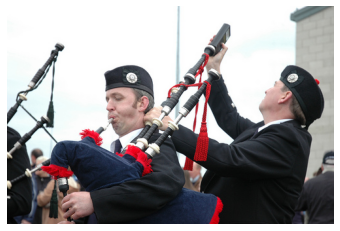

man in red shirt and tie


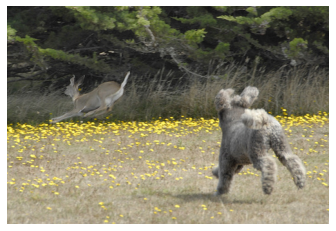

dog running through field


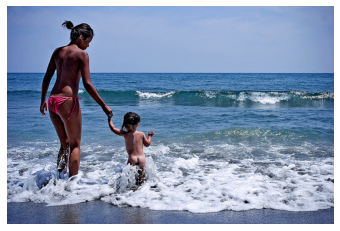

man in wetsuit is standing on the beach


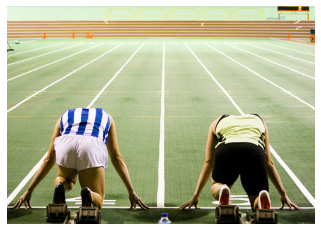

two girls are sitting on bench in front of an amusement park


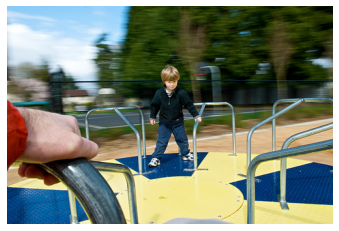

man in blue shirt and jeans sits on bench


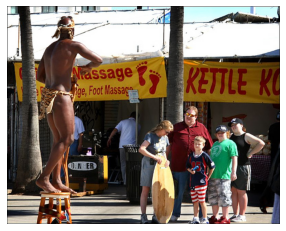

two men are sitting on the ground near the window


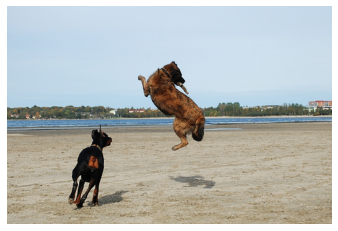

dog jumping into the water


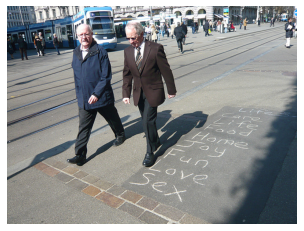

man in black shirt and black leather is walking down city street


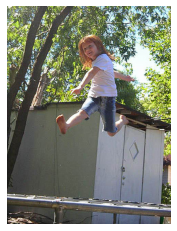

young boy is jumping on trampoline


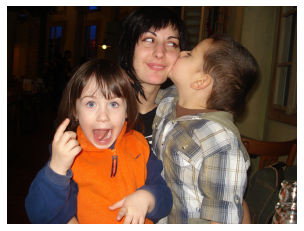

woman with mohawk hair and woman in black shirt


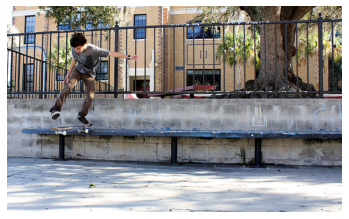

man in black shirt is jumping on railing


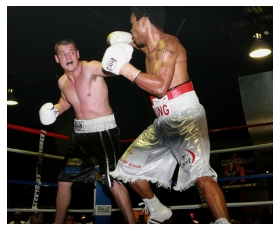

man in white shirt and white shorts is playing tennis


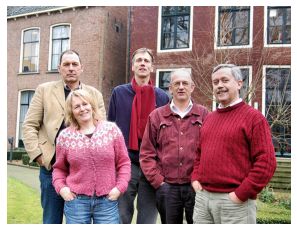

two men are standing in front of monument


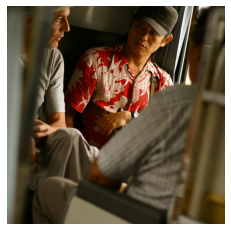

man in blue shirt and black shirt is sitting in front of art poster


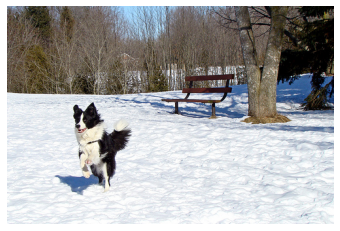

two dogs are pulling in the snow


In [81]:
#pick saome random images
for i in range(15):
  idx=np.random.randint(0,1000)
  all_img_name=list(encoding_test.keys())
  img_name=all_img_name[idx]
  photo_2048=encoding_test[img_name].reshape((1,2048))

  i=plt.imread(IMG_PATH+img_name+".jpg")
  caption=predict_caption(photo_2048)
  
  plt.axis("off")
  plt.imshow(i)
  plt.show()

  print(caption)